In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
import os
import random
from community import community_louvain
import pandas as pd

### Read the final network

In [2]:
# Define the path to the GEXF file
file_path = r'./../networks/One_Piece.gexf'  

# Load the graph from the GEXF file
G = nx.read_gexf(file_path)

# Set random seed for reproducibility
random.seed(42)

# Perform Louvain community detection
louvain_partition = community_louvain.best_partition(G, resolution=1, randomize=False)

# Group nodes by their community
communities_louvain = defaultdict(list)
for node, community in louvain_partition.items():
    communities_louvain[community].append(node)

# Sort communities by the size (number of nodes) in descending order
sorted_communities = sorted(communities_louvain.items(), key=lambda x: len(x[1]), reverse=True)

# Output the results
print(f"Number of Communities: {len(sorted_communities)}")
print("Communities sorted by size:")
for i, (community_id, nodes) in enumerate(sorted_communities, 1):
    print(f"- Community {i} (ID: {community_id}): {len(nodes)} nodes")

Number of Communities: 24
Communities sorted by size:
- Community 1 (ID: 3): 109 nodes
- Community 2 (ID: 7): 95 nodes
- Community 3 (ID: 8): 95 nodes
- Community 4 (ID: 1): 73 nodes
- Community 5 (ID: 13): 67 nodes
- Community 6 (ID: 15): 61 nodes
- Community 7 (ID: 2): 59 nodes
- Community 8 (ID: 11): 42 nodes
- Community 9 (ID: 0): 8 nodes
- Community 10 (ID: 9): 6 nodes
- Community 11 (ID: 16): 6 nodes
- Community 12 (ID: 19): 4 nodes
- Community 13 (ID: 17): 2 nodes
- Community 14 (ID: 18): 2 nodes
- Community 15 (ID: 10): 1 nodes
- Community 16 (ID: 14): 1 nodes
- Community 17 (ID: 20): 1 nodes
- Community 18 (ID: 21): 1 nodes
- Community 19 (ID: 22): 1 nodes
- Community 20 (ID: 23): 1 nodes
- Community 21 (ID: 12): 1 nodes
- Community 22 (ID: 4): 1 nodes
- Community 23 (ID: 5): 1 nodes
- Community 24 (ID: 6): 1 nodes


Visualization of the communit partition of the external network, made with ForceAtlas2 model in [Gephi](https://gephi.org/)
![Fig](../Images/network%20partition.png)

### Function to process text

In [4]:
# Function to lemmatize each word based on its part of speech
def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)

# Function to process the content text
def process_text(content, lemmatize=False):
    # Words to remove
    words_to_remove = ["wa", "new", "also", "one", "two", "told", "luffy", "even", "however", "could", "became", "would", "ha", "take", "like", "though", "upon"]

    # Tokenize the content into individual words
    tokens = word_tokenize(content)

    # Remove punctuation and convert to lower case
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Lemmatize the tokens if required
    if lemmatize:
        tokens = [lemmatize_word(word) for word in tokens]

    # Filter out rare words that appear less than 5 times
    token_counts = Counter(tokens)
    tokens = [word for word in tokens if token_counts[word] >= 5]

    # Filter out stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Remove specified words
    tokens = [word for word in tokens if word not in words_to_remove]

    return tokens

### TF-IDF on communities

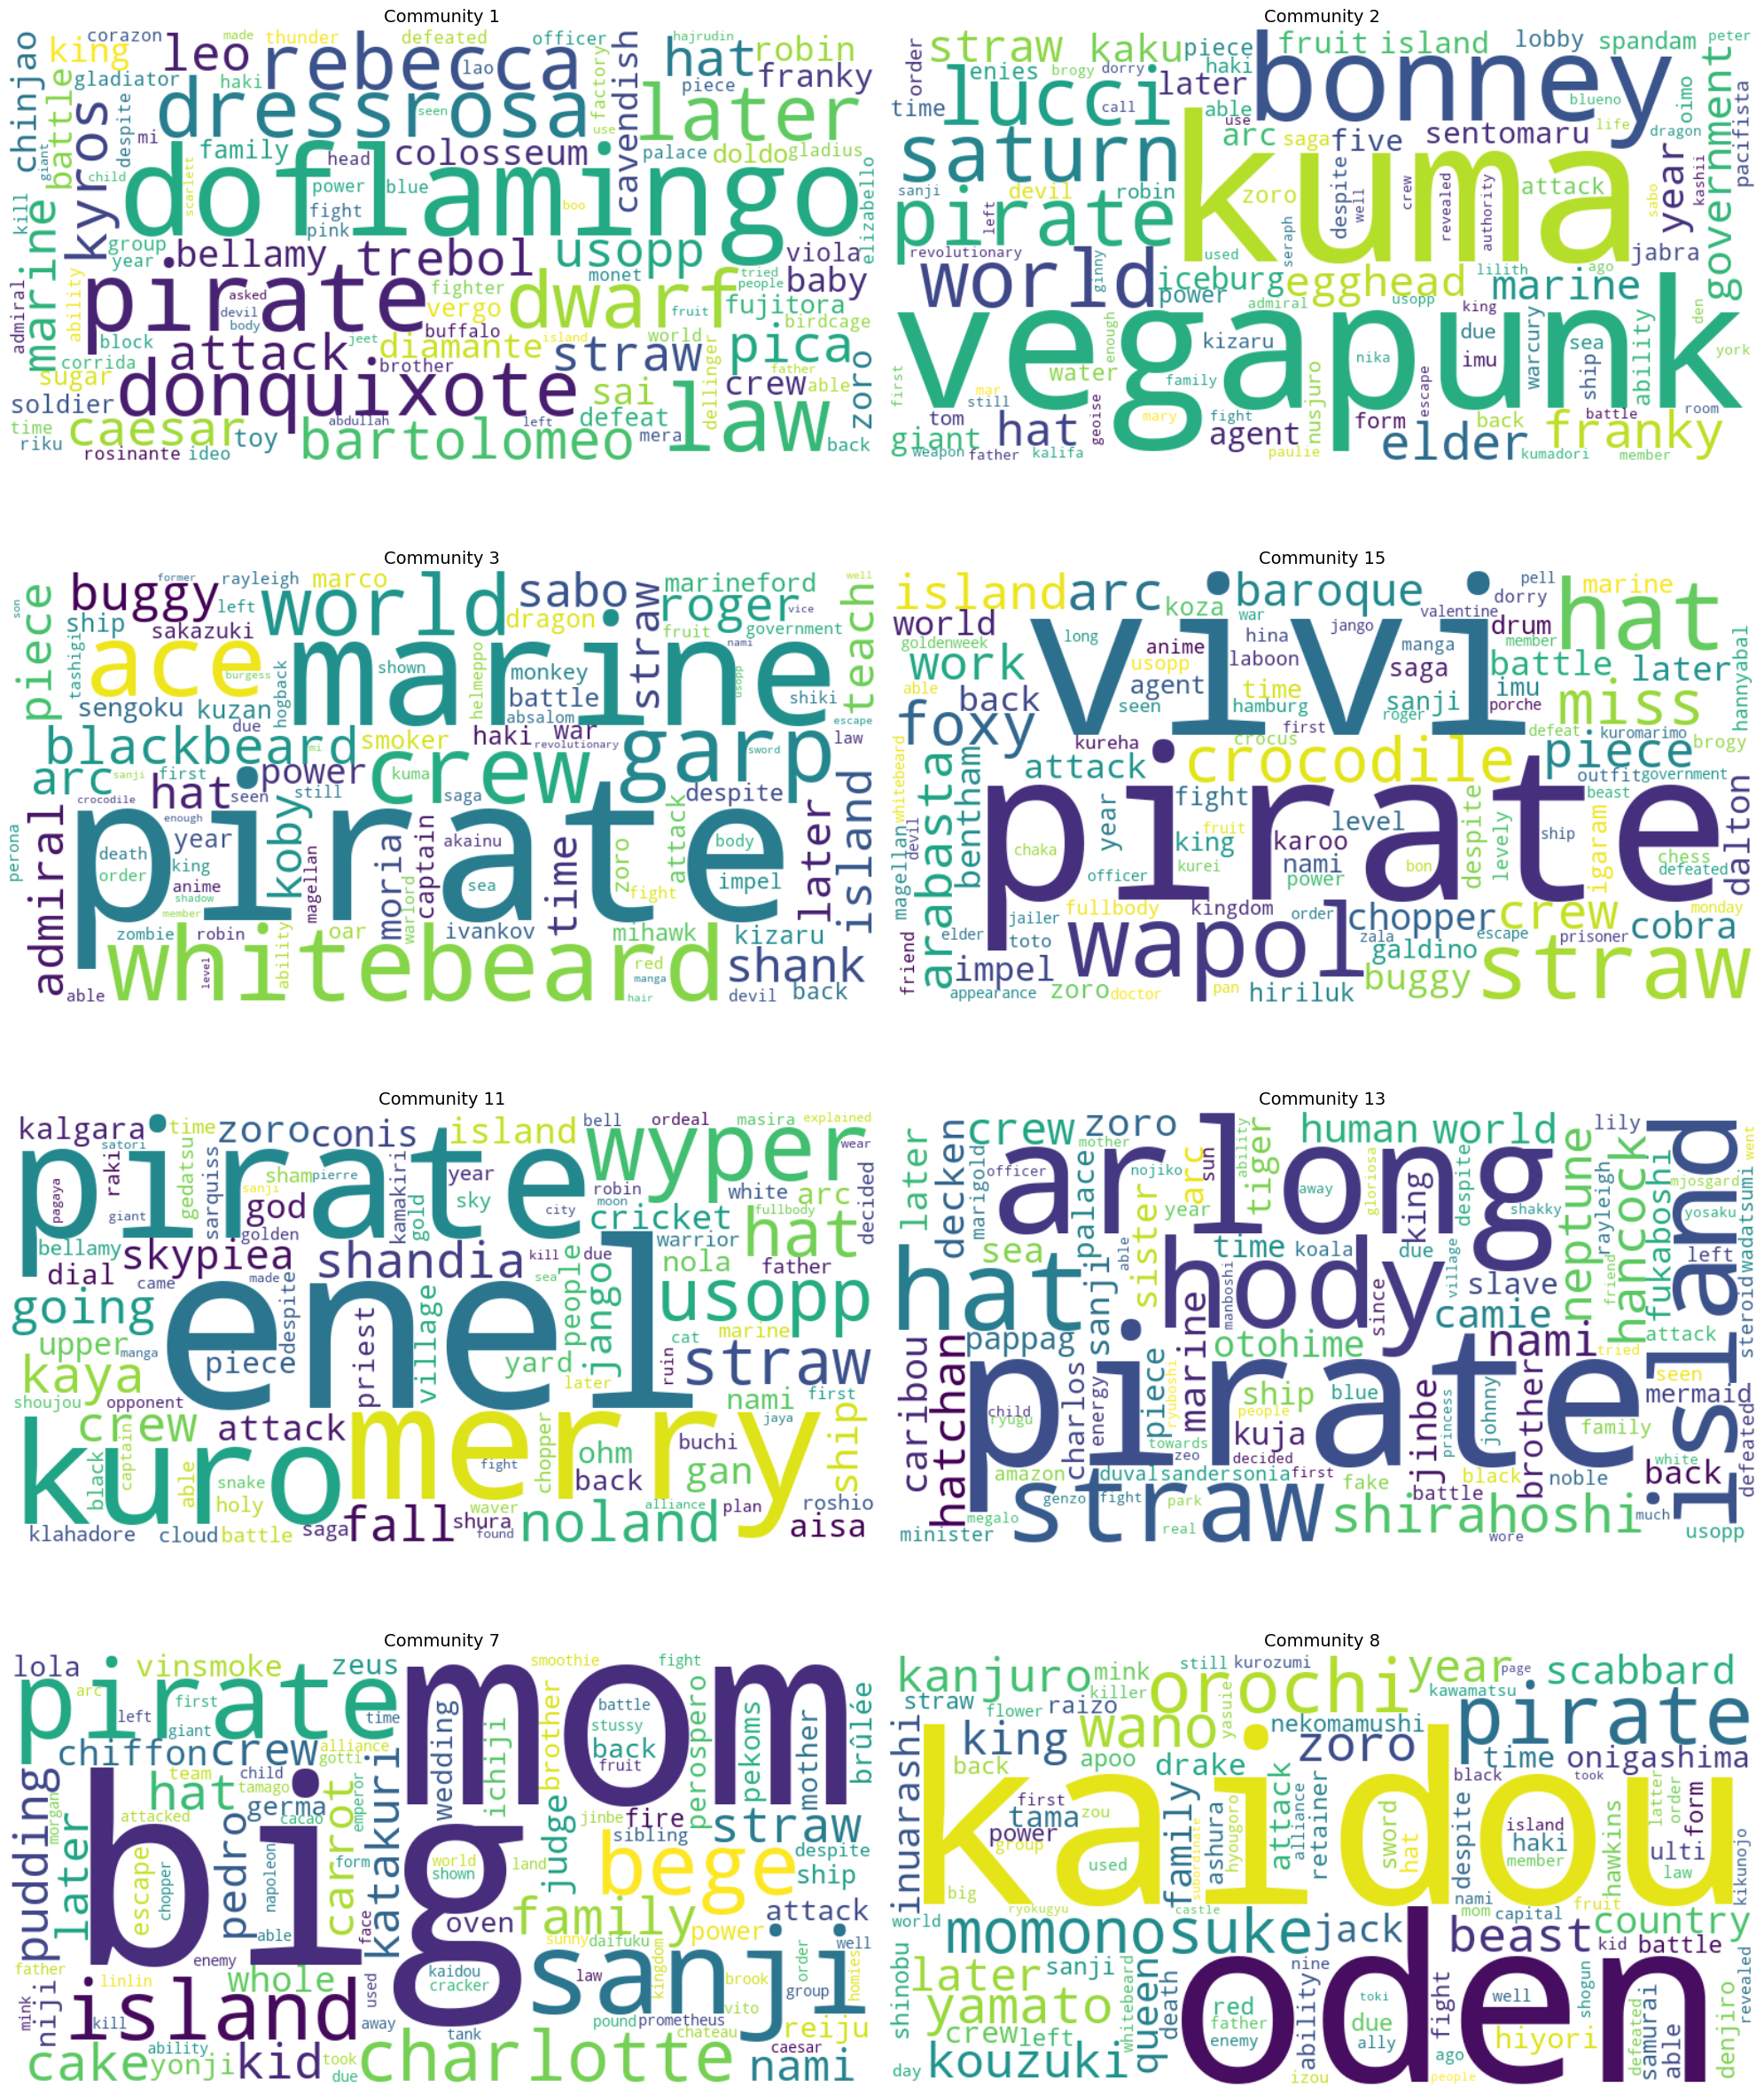

In [5]:
text_dir = r"./../onepiece_cleaned" 

# Prepare content for each community
communities_content = {}
for community, members in communities_louvain.items():
    if len(members) < 9:  # Skip communities with less than 6 members
        continue
    communities_content[community] = []
    for node in members:
        filename = os.path.join(text_dir, f"{node}.txt")
        if os.path.exists(filename):
            # Read and clean the content of each file
            with open(filename, 'r', encoding='utf-8') as file:
                raw_content = file.read()
                cleaned_content = " ".join(process_text(raw_content, lemmatize=True))
                communities_content[community].append(cleaned_content)

# Prepare word clouds for up to 10 communities
fig, axes = plt.subplots(4, 2, figsize=(20, 25))  # Create a 5x2 grid for subplots
axes = axes.flatten()

# Generate word clouds
for i, (community, contents) in enumerate(communities_content.items()):
    if i >= 10:  # Limit to 10 communities
        break
    
    # Merge all text content in the community
    merged_content = " ".join(contents)
    
    # Perform TF-IDF analysis
    vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features
    X = vectorizer.fit_transform([merged_content])
    tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().flatten()))
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Community {community}", fontsize=14)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Load the arcs JSON data
arcs_file_path = r'./../json_files/character_to_arcs.json'
with open(arcs_file_path, 'r') as file:
    arcs_data = json.load(file)

### Correlation Community-Saga Analysis

In [10]:
# Define logical segmentation of arcs based on story progression
arc_segments = {
    "East Blue Saga": [
        "Romance Dawn Arc", "Orange Town Arc", "Syrup Village Arc",
        "Baratie Arc", "Arlong Park Arc", "Loguetown Arc"
    ],
    "Alabasta Saga": [
        "Reverse Mountain Arc", "Whisky Peak Arc", "Little Garden Arc",
        "Drum Island Arc", "Arabasta Arc"
    ],
    "Sky Island Saga": ["Jaya Arc", "Skypiea Arc"],
    "Water 7 Saga": [
        "Long Ring Long Land Arc", "Water 7 Arc", "Enies Lobby Arc", "Post-Enies Lobby Arc"
    ],
    "Thriller Bark Saga": ["Thriller Bark Arc"],
    "Summit War Saga": [
        "Sabaody Archipelago Arc", "Amazon Lily Arc", "Impel Down Arc",
        "Marineford Arc", "Post-War Arc"
    ],
    "Fish-Man Island Saga": ["Return to Sabaody Arc", "Fish-Man Island Arc"],
    "Dressrosa Saga": ["Punk Hazard Arc", "Dressrosa Arc"],
    "Yonko Saga": [
        "Zou Arc", "Whole Cake Island Arc", "Levely Arc", "Wano Country Arc", "Egghead Arc"
    ]
}

# Map arcs to sagas
arc_to_saga = {arc: saga for saga, arcs in arc_segments.items() for arc in arcs}

# Function to compute first appearance arcs for characters
def compute_first_appearance(sorted_character_arcs):
    return {char: arcs[0] for char, arcs in sorted_character_arcs.items() if arcs}

# Function to sort arcs for each character based on the chronological order
def sort_arcs_for_characters(arcs_data, sorted_arcs):
    arc_order = {arc: idx for idx, arc in enumerate(sorted_arcs)}
    return {
        char: sorted(arcs, key=lambda arc: arc_order.get(arc, float('inf')))
        for char, arcs in arcs_data.items()
    }

# Function to prepare a DataFrame showing saga-community associations
def prepare_saga_dataframe(communities, sorted_character_arcs):
    first_appearance = compute_first_appearance(sorted_character_arcs)
    community_saga_data = defaultdict(lambda: defaultdict(int))

    for community_id, nodes in communities:
        if len(nodes) < 9:  # Skip small communities
            continue
        for node in nodes:
            arc = first_appearance.get(node)
            if arc:
                saga = arc_to_saga.get(arc)
                if saga:
                    community_saga_data[community_id][saga] += 1

    return pd.DataFrame.from_dict(
        {saga: {cid: community_saga_data[cid].get(saga, 0) for cid in community_saga_data}
         for saga in arc_segments},
        orient="index"
    ).fillna(0).astype(int)

# Example usage
# Chronological order of arcs
sorted_arcs = [
    "Romance Dawn Arc", "Orange Town Arc", "Syrup Village Arc", "Baratie Arc", "Arlong Park Arc",
    "Loguetown Arc", "Reverse Mountain Arc", "Whisky Peak Arc", "Little Garden Arc", "Drum Island Arc",
    "Arabasta Arc", "Jaya Arc", "Skypiea Arc", "Long Ring Long Land Arc", "Water 7 Arc",
    "Enies Lobby Arc", "Post-Enies Lobby Arc", "Thriller Bark Arc", "Sabaody Archipelago Arc",
    "Amazon Lily Arc", "Impel Down Arc", "Marineford Arc", "Post-War Arc", "Return to Sabaody Arc",
    "Fish-Man Island Arc", "Punk Hazard Arc", "Dressrosa Arc", "Zou Arc", "Whole Cake Island Arc",
    "Levely Arc", "Wano Country Arc", "Egghead Arc"
]

# Sort arcs for characters
sorted_character_arcs = sort_arcs_for_characters(arcs_data, sorted_arcs)

# Create the DataFrame for saga-community associations
df_sagas_first_appearance = prepare_saga_dataframe(sorted_communities, sorted_character_arcs)

# Move columns so it is sorted numerically
df_sagas_first_appearance = df_sagas_first_appearance.reindex(sorted(df_sagas_first_appearance.columns), axis=1)

display(df_sagas_first_appearance)

1   2   3   7   8   11  13  15
East Blue Saga         1   1  30   1   4  11  15   2
Alabasta Saga          0   1   4   2   2   0   3  35
Sky Island Saga        2   6  12   1   1  28   0   1
Water 7 Saga           3  25   9   0   0   0   1   6
Thriller Bark Saga     0   1  14   1   1   0   2   1
Summit War Saga        4   5  23   3   8   0  16  10
Fish-Man Island Saga   0   0   0   5   1   0  29   0
Dressrosa Saga        59   2   1   5  12   0   0   0
Yonko Saga             0  16  10  72  58   0   1   3

### TF-IDF on Sagas

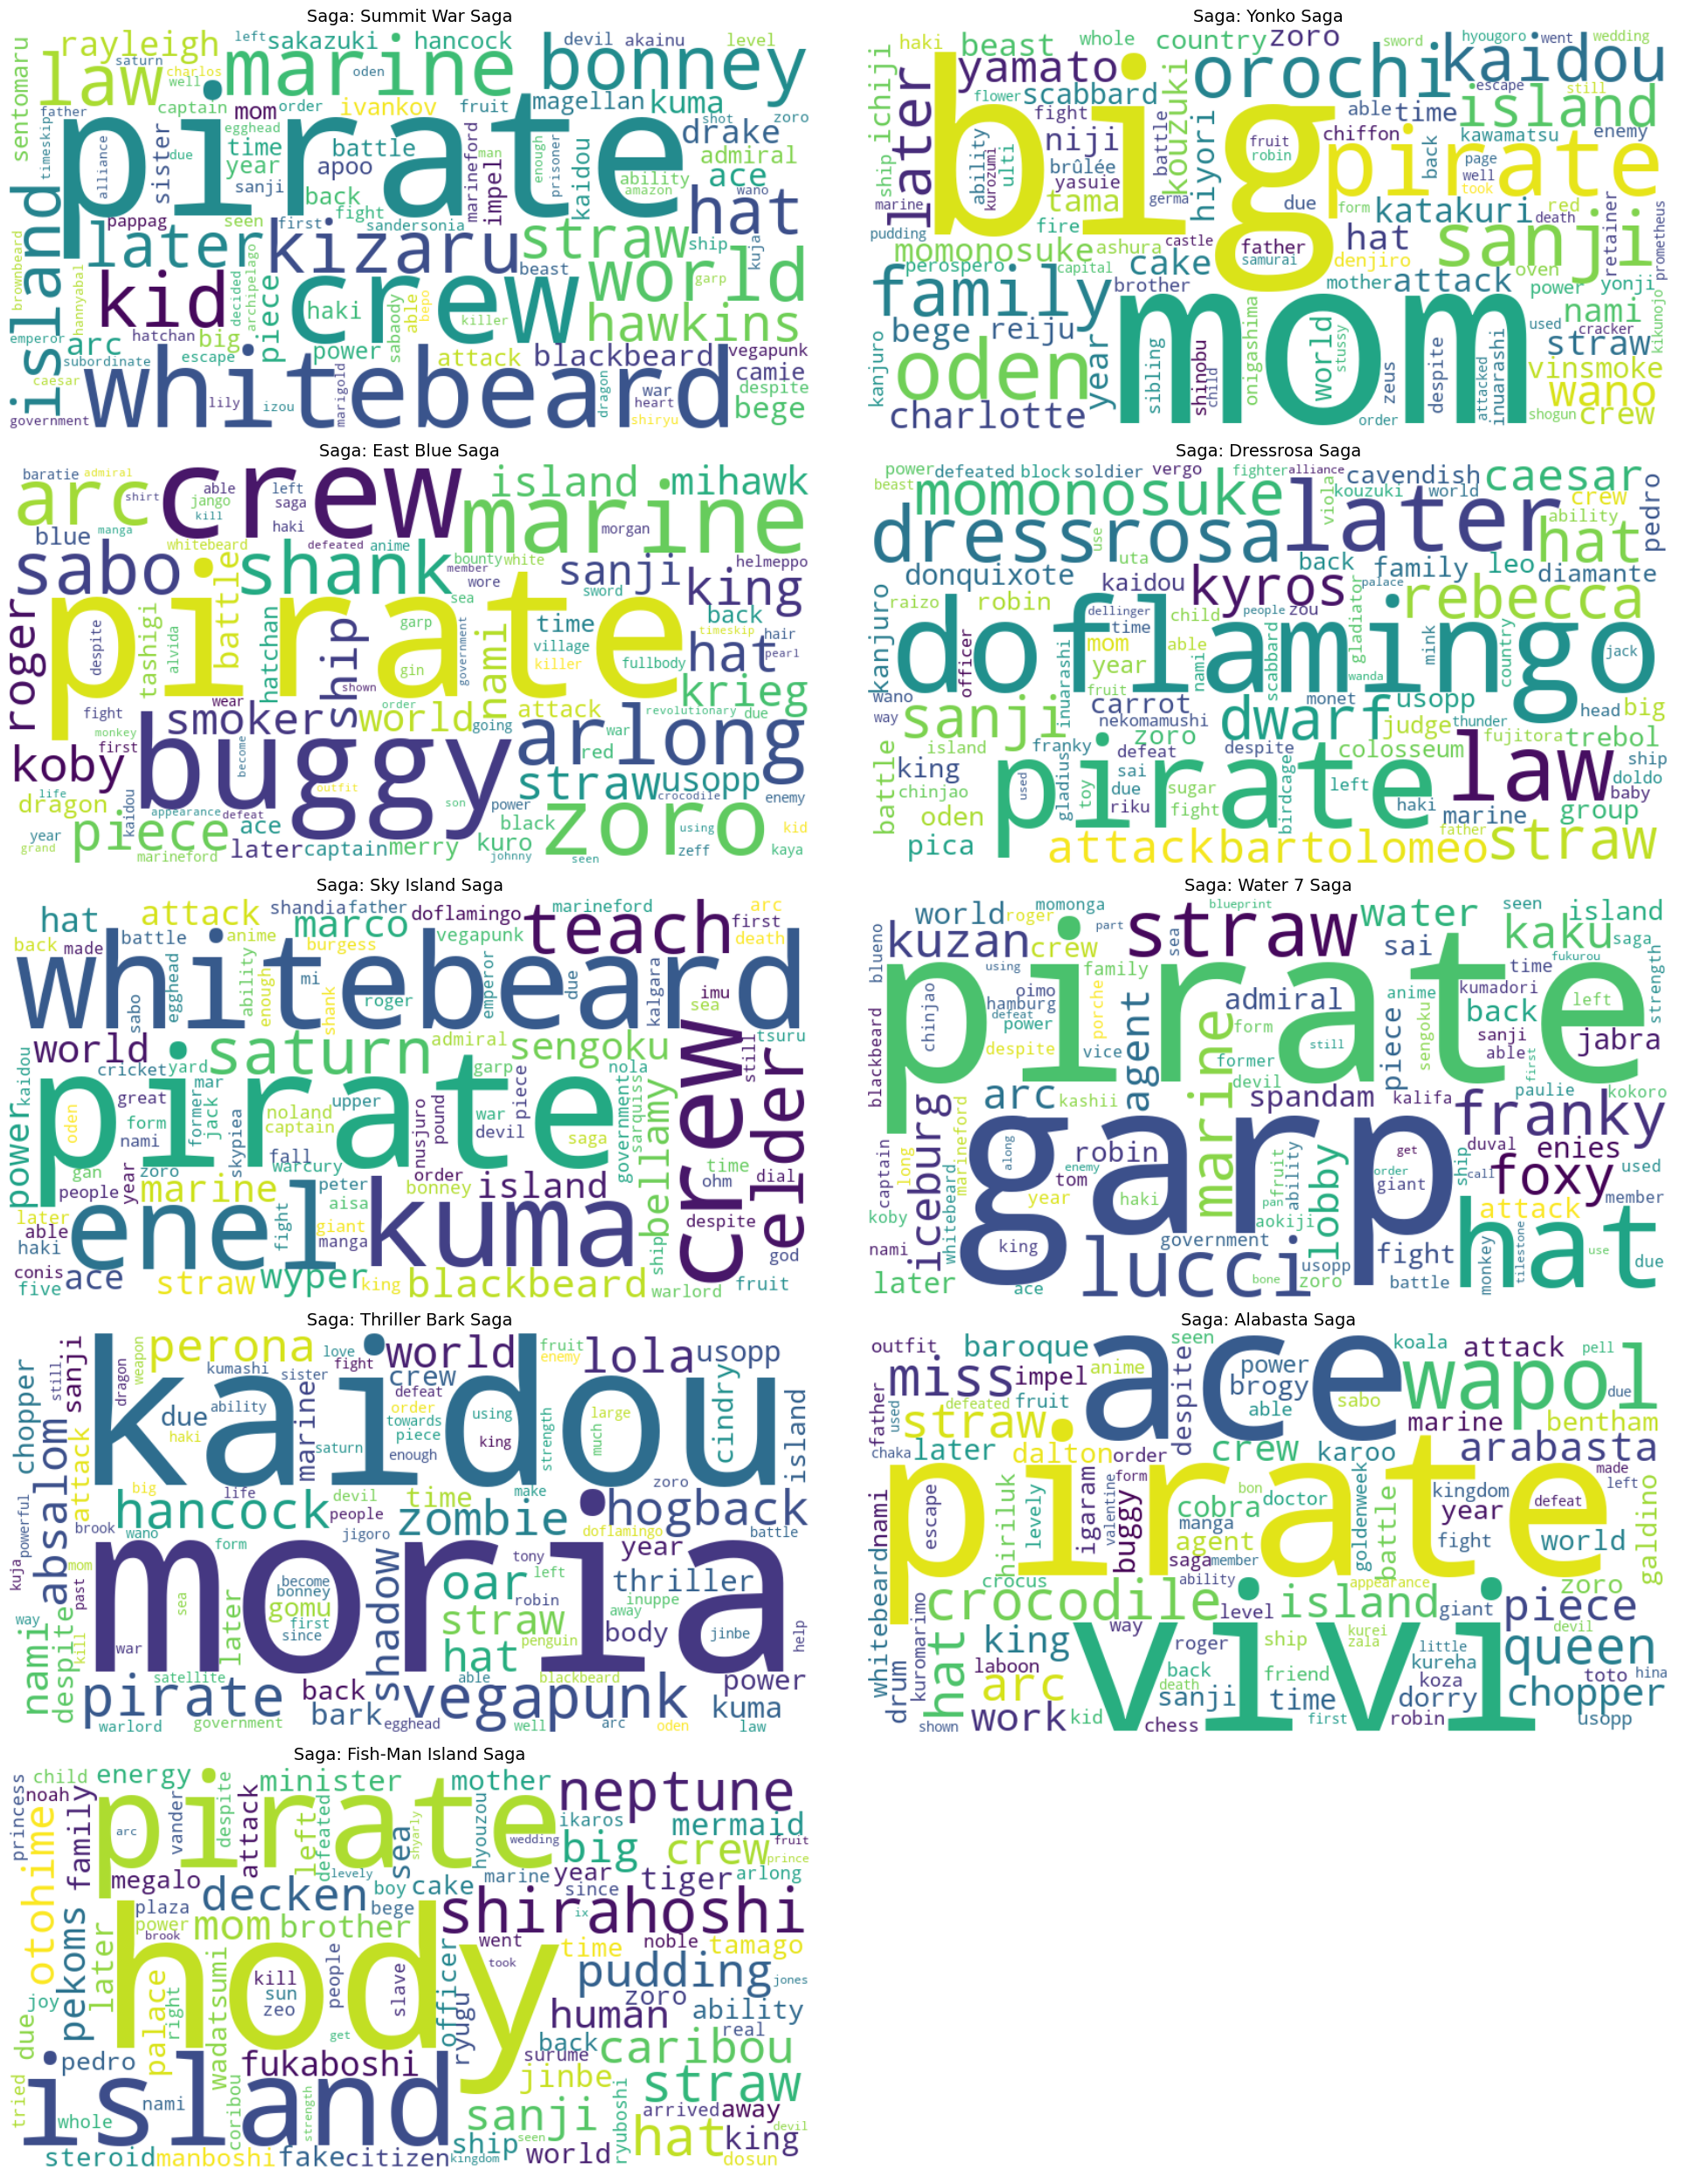

In [ ]:
# Function to prepare word clouds for characters' first appearances
def generate_first_appearance_wordclouds(communities_louvain, sorted_character_arcs, text_dir):
    first_appearance = compute_first_appearance(sorted_character_arcs)
    
    # Prepare content for each character's first appearance
    character_content = {}
    
    for community, members in communities_louvain.items():
        for node in members:
            arc = first_appearance.get(node)
            if arc:
                saga = arc_to_saga.get(arc)
                if saga:
                    filename = os.path.join(text_dir, f"{node}.txt")
                    if os.path.exists(filename):
                        # Read and clean the content of the file
                        with open(filename, 'r', encoding='utf-8') as file:
                            raw_content = file.read()
                            cleaned_content = " ".join(process_text(raw_content, lemmatize=True))
                            
                            if saga not in character_content:
                                character_content[saga] = []
                            character_content[saga].append(cleaned_content)

    # Generate word clouds for the first appearance of characters in each saga
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))  # Create a 4x2 grid for subplots
    axes = axes.flatten()
    
    for i, (saga, contents) in enumerate(character_content.items()):
        if i >= 10:  # Limit to the first 10 sagas
            break
        
        # Merge all text content in the saga
        merged_content = " ".join(contents)
        
        # Perform TF-IDF analysis
        vectorizer = TfidfVectorizer(max_features=100)  # Limit to top 100 features
        X = vectorizer.fit_transform([merged_content])
        tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().flatten()))
        
        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tfidf_scores)
        
        # Plot the word cloud in the corresponding subplot
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].axis("off")
        axes[i].set_title(f"Saga: {saga}", fontsize=14)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function to generate word clouds
generate_first_appearance_wordclouds(communities_louvain, sorted_character_arcs, text_dir)